In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import load_model
from common_variables import *

In [7]:
np.random.seed(seed)
tf.random.set_random_seed(seed)

In [8]:
df = pd.read_csv(test_time_series_path, dayfirst = True, index_col=['Date_Time'], parse_dates=['Date_Time'], usecols=['Date_Time','HLAvg','MA','Returns'])

In [9]:
# 加载训练模型
scaler = joblib.load(scaler_path)
# transform 将数据标准化，更容易查看外汇价格变化的趋势
df['Scaled'] = scaler.transform(df[['Returns']].values)

In [10]:
model = load_model(model_path)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
scaled = df['Scaled'].values
X = []
len_scaled = len(scaled)
for i in range(window_size, len_scaled):
    X.append(scaled[i-window_size:i])
X = np.asarray(X)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
y_true = scaled[-X.shape[0]:]
print(f"X {X.shape}, y_real {y_true.shape}")

X (5184, 256, 1), y_real (5184,)


In [12]:
# 通过 evaluate() 在测试数据上评估模型
mse = model.evaluate(X, y_true, verbose=1)
print("Mean Squared Error:", mse)

5184/5184 [==============================] - 5s 876us/sample - loss: 4.9517e-05

In [13]:
# 预测结果
y_pred = model.predict(X)
y_pred.shape

(5184, 1)

In [14]:
df['Pred_Scaled'] = np.pad(y_pred.reshape(y_pred.shape[0]), (window_size, 0), mode='constant', constant_values=np.nan)
df['Pred_Returns'] = scaler.inverse_transform(df[['Pred_Scaled']].values)
#df['Pred_MA'] = df["MA"].mul(1 + df['Pred_Returns'].shift(-1)).shift(1) # Arithmetic Returns
df['Pred_MA'] = df['MA'].mul(np.exp(df['Pred_Returns'].shift(-1))).shift(1) # Log Returns
df = df[window_size:]
df

,HLAvg,MA,Returns,Scaled,Pred_Scaled,Pred_Returns,Pred_MA
Date_Time,,,,,,,
2001-01-01,124.140,124.101429,0.000049,0.595359,0.592709,4.480205e-05,124.100919
2001-01-01,124.130,124.105714,0.000035,0.586109,0.586572,3.525429e-05,124.105808
2001-01-01,124.140,124.110000,0.000035,0.586108,0.581368,2.715728e-05,124.109087
2001-01-01,124.125,124.112500,0.000020,0.576860,0.583998,3.124932e-05,124.113876
2001-01-01,124.105,124.114286,0.000014,0.573161,0.577278,2.079340e-05,124.115074
...,...,...,...,...,...,...,...
2001-01-01,124.780,124.765714,0.000003,0.565753,0.562125,-2.782270e-06,124.765008
2001-01-01,124.770,124.764643,-0.000009,0.558394,0.563653,-4.052743e-07,124.765662
2001-01-01,124.770,124.763929,-0.000006,0.560233,0.560617,-5.128662e-06,124.764003


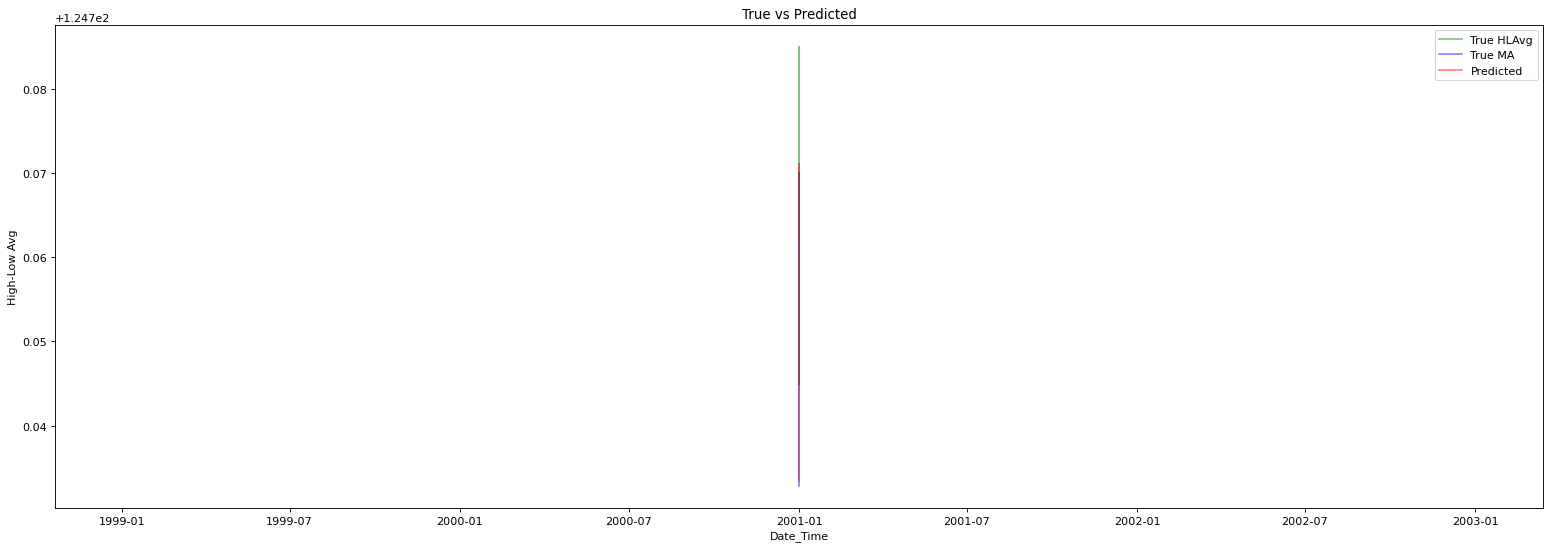

In [15]:
plt.figure(figsize=(24, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df['HLAvg'][-20:], color = 'green', label = 'True HLAvg', alpha=0.5)
plt.plot(df['MA'][-20:], color = 'blue', label = 'True MA', alpha=0.5)
plt.plot(df['Pred_MA'][-20:], color = 'red', label = 'Predicted', alpha=0.5)
plt.title('True vs Predicted')
plt.xlabel('Date_Time')
plt.ylabel('High-Low Avg')
plt.legend()
plt.show()